In [1]:
from __future__ import division
import pandas as pd
import subprocess, os
import httplib
import numpy as np
import json, requests
from netaddr import IPNetwork, IPAddress
from collections import defaultdict

SAMPLENAME = "sIP_sanitize_20150426/"
#SAMPLENAME = "validate_20150422"
DATAPATH = "data/sIP_sanitize/"
DATAPATH2 = "results/validated_20150422/"

RESULTS = "results/" + SAMPLENAME
if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

# SIP and DOMAINS to REJECT

In [3]:
# Load sIP:domain:subcat list
df_sIP_info = pd.read_csv(DATAPATH + "Servers_IMC.txt.original")
df_sIP_info['subcat'] = df_sIP_info['subcat'].apply(lambda x:x.split("|"))
print len(df_sIP_info)
df_sIP_info.head()

580


,sIP,domain,subcat
0,23.235.33.64,deadspin.com,[sports]
1,216.239.38.21,uproxy.org,[circum]
2,41.185.22.146,medihelp.co.za,[world]
3,184.73.236.82,history.com,"[kids_and_teens, arts, business]"
4,23.212.53.230,navbharattimes.indiatimes.com,"[news, world]"


# Checks: IP-reachability, domain-IP-relevance, high-censorship
- maintain an sIP_info table using df_sIP_subcat
- add IP-reachability, domain-IP-relevance, and censorship info to it

## IP-reachability: Spooky-scan fails on anycast
- ANYCAST_DESC: does IP belong to Anycast list: Cloudflare, amazon, etc
- REVERSE_DNS: sIP reverse DNS using dig @8.8.8.8 contains aws etc.
- SLASH24, SHARED_SLASH24: IPs that share a slash24 with others on the list: suspected CDNs

## domain-IP-relevance: sIP to Domain mapping
- DNS_LIST, DNS_CONTAINS_IPADDR: DNS query for domain: contains sIP?
- HTTP_DOMAIN, HTTP_IP, HTTP_IP_CONTAINS_DOMAIN, HTTP_DIFF: http download for domain works (check1) and is the same as http download for sIP (check2)

## high-censorship: Censorship ratios for US and SE
- type1
- type2
- type3
- type4

#1. IP-reachability:
- Spooky scan fails to detect censorship at gIP if the sIP itself is protecting its IP layer

- sIPs can use firewalls that don't allow measurements without knowing the host
    - for example popular websites like reddit are hosted on cloudflare
    - although we can connect (telnet port 80) to them, they do not allow direct access

- sIPs can be anycasted (for example popular CDNs) and refer to different machine
    - similar to firewall issue, a proxy machine may decide where to route the connection based on host info
 
- these websites are usually not reacheable directly via IP, but are valid websites
- if we do not weed them out, they will appear as censorship. In reality they are limitations of spooky-scan that are server-side unreacheable (unmeasureable?) due to firewalls or anycast. (they are usually CDNs).

#### Weeding out sIPs spooky scan cannot measure:
- anycast sIPs: unfortunately detecting anycast is a huge research problem not tackled by us
    - we download list of popular anycasting CDNs
    - we find their IP prefixes using BGP updates
    - we find sIPs that may belong to anycast
- reverse DNS: may show akamai or aws, which are also popular anycast
- slash24: many google sIPs seem to belong to the same /24 prefix. In case something is not in the anycast list, we find sIPs with common /24

#### Create a copy frame to add IP-reachability info to

In [90]:
sIP_info = df_sIP_info.copy()

#### Load Anycast

In [27]:
# Load ANYCASTERS
df_anycast_temp = pd.read_csv(DATAPATH + "anycasters.txt", names=["ip_prefix", "description"], delimiter='\t')

with open(DATAPATH + 'anycast-ip-range_amazon.json') as data_file:    
    data = json.load(data_file)
amazon = pd.DataFrame(data['prefixes'])
amazon['description'] = amazon['description'] = amazon['region']+"|"+amazon['service']

df_anycast = pd.concat([df_anycast_temp, amazon[['ip_prefix', 'description']]])
del df_anycast_temp, amazon

df_anycast.to_csv(DATAPATH + "anycast_complete.csv")
df_anycast.head()

,ip_prefix,description
0,23.10.240.0/24,"Akamai Technologies, Inc. United States"
1,23.34.0.0/20,"Akamai Technologies, Inc. United States"
2,23.79.224.0/20,"Akamai International, BV United States"
3,63.208.195.0/24,Akamai Customer Care United States
4,72.246.0.0/22,"Akamai Technologies, Inc. United States"


#### Store anycast if any sIP belongs to the prefixes

In [51]:
def check_ip_prefix(sIP):
    for prefix in list( df_anycast['ip_prefix'] ):
        if IPAddress(sIP) in IPNetwork(prefix):
            return df_anycast[df_anycast['ip_prefix'] == prefix]['description'].values[0]
    return -1

In [52]:
sIP_info['anycast'] = sIP_info['sIP'].apply(check_ip_prefix)

#### Get reverse DNS and store in dig_x column

In [30]:
def get_revDNS(ipaddr):
    try:
        return subprocess.check_output("dig -x "+ipaddr+" @8.8.8.8 +short", shell=True).split()
    except:
        return -1

In [31]:
sIP_info['dig_x'] = sIP_info['sIP'].apply(get_revDNS)

#### sIPs with shared /24 within the sIP list

In [84]:
sIP_info['slash24'] = sIP_info['sIP'].apply(lambda x:x[:x.rfind(".")])
df_IP_reachability = sIP_info.merge( sIP_info.groupby('slash24')['sIP'].count().reset_index().rename(
        columns={'sIP':'slash24_shared'}), on='slash24')

#### Store this data frame regarding IP reachability

In [86]:
df_IP_reachability.to_pickle(RESULTS + "df_IP_reachability.pkl")
df_IP_reachability.head()

,sIP,domain,subcat,dig_x,anycast,slash24,slash24_shared
0,23.235.33.64,deadspin.com,[sports],[],-1,23.235.33,2
1,23.235.33.217,vimeo.com,[computers],[],-1,23.235.33,2
2,216.239.38.21,uproxy.org,[circum],[any-in-2615.1e100.net.],Google Inc. United States,216.239.38,1
3,41.185.22.146,medihelp.co.za,[world],[],-1,41.185.22,1
4,184.73.236.82,history.com,"[kids_and_teens, arts, business]",[ec2-184-73-236-82.compute-1.amazonaws.com.],us-east-1|AMAZON,184.73.236,1


#2. Domain-IP relevance

#### Use original df_sIP_info without reachability data

In [91]:
sIP_info = df_sIP_info.copy()

#### DNS Query for domain: does it contain the IPAddr?

In [92]:
def get_DNS(domain):
    try:
        dig = subprocess.check_output("dig @8.8.8.8 "+domain+" +short", shell=True).split()
    except:
        dig = -1
    return dig

In [93]:
sIP_info['dig'] = sIP_info['domain'].apply(get_DNS)

In [109]:
sIP_info['DNS_contains'] = sIP_info.apply(lambda row: row['sIP'] in row['dig'], axis=1)

#### HTTP Check domain
- http connect to domain
    - store the code (should be 200)
    - if error code try www
    - if error code try https
    - whoever gives no error, store in results/curl/QUERY.html using a curl subprocess

In [232]:
def get_code(domain):
    try:
        req =  urllib2.urlopen("http://"+domain+"/", timeout=2)
        return req.getcode()
    except urllib2.HTTPError, err:
        return err.code
    except Exception,err:
        if 'code' in err:
            return err.code
        else:
            # try 10 times
            for i in range(10):
                try:
                    req =  urllib2.urlopen("http://"+domain+"/", timeout=16)
                    code = req.getcode()
                    print domain, code, "loop: ", i
                    return code
                except:
                    pass
            print domain, err, "final"
            return -1

# httplib is actually unable to get many 200 codes
http_errors = defaultdict(list)

def get_http_code(domain):
    try:
        # this catches relocation
        conn = httplib.HTTPConnection(domain)
        conn.request("HEAD", "")
        res = conn.getresponse()
        if res.status !=200:
            print domain, res.status, res.reason
            
            http_errors['domain'].append(domain)
            http_errors['status'].append(res.status)
            http_errors['reason'].append(res.reason)
            http_errors['header'].append(res.getheaders())
    
        return res.status
    except Exception, e:
        print domain, e
        return -1

In [115]:
sIP_info['http_domain'] = sIP_info['domain'].apply(get_code)

uproxy.org <urlopen error [Errno 8] _ssl.c:510: EOF occurred in violation of protocol> final
livejasmin.com 200 loop:  0 imlive.com '' final
uj.ac.za 200 loop:  0 suicidegirls.com 200 loop:  0 kyknet.dstv.com 200 loop:  0 rsg.co.za 200 loop:  0 www.coursera.org <urlopen error [Errno 1] _ssl.c:510: error:14077410:SSL routines:SSL23_GET_SERVER_HELLO:sslv3 alert handshake failure> final
watkykjy.co.za 200 loop:  0 asexstories.com 200 loop:  0 groupon.com 200 loop:  0 torDir <urlopen error [Errno -2] Name or service not known> final
torDir <urlopen error [Errno -2] Name or service not known> final
torDir <urlopen error [Errno -2] Name or service not known> final
torDir <urlopen error [Errno -2] Name or service not known> final
torDir <urlopen error [Errno -2] Name or service not known> final
torDir <urlopen error [Errno -2] Name or service not known> final


In [157]:
# Do not use this it really sucks, even though it catches redirections its a shit library
# sIP_info['http_domain2'] = sIP_info['domain'].apply(get_http_code)

#### Apart from torDir, there shouldn't be any codes other than 200 here
- if code other than 200 exists, try the domain with httplib: this gives relocations (www or https or a new relocated home page)
- manual check shows that www works for most missing domains, and https for vpn domains.

In [178]:
retry_domain = sIP_info[ (sIP_info['http_domain']!=200) & (sIP_info['domain']!='torDir')]
print len(retry_domain)
retry_domain.head()

54


,sIP,domain,subcat,dig,DNS_contains,http_domain,http_domain2
1,216.239.38.21,uproxy.org,[circum],"[216.239.32.21, 216.239.38.21, 216.239.36.21, ...",True,-1,301
14,172.224.251.210,marriott.com,"[recreation, regional]",[23.37.11.210],False,403,301
35,23.235.47.133,fortawesome.github.io,[kids_and_teens],"[github.map.fastly.net., 199.27.75.133]",False,404,404
45,172.224.252.119,travelzoo.com,[recreation],[23.37.10.226],False,403,301
62,162.159.241.236,nordvpn.com,[vpn],"[162.159.240.236, 162.159.241.236]",True,403,301


In [179]:
sIP_info['http_domain2'] = retry_domain['domain'].apply(get_http_code)

uproxy.org 301 Moved Permanently
marriott.com 301 Moved Permanently
fortawesome.github.io 404 Not Found
travelzoo.com 301 Moved Permanently
nordvpn.com 301 Moved Permanently
imlive.com 301 Moved Permanently
brainyquote.com 301 Moved Permanently
republikein.com.na 301 Moved Permanently
mmo-champion.com 301 Moved Permanently
curse.com 301 Moved Permanently
lufthansa.com 301 Moved Permanently
studentdoctor.net 301 Moved Permanently
fda.gov 400 Bad Request
thefind.com 503 Service Temporarily Unavailable
nyu.edu 302 Found
masrawy.com 302 Found
tomshardware.com 416 Requested Range Not Satisfiable
myegy.com 302 Moved Temporarily
kohls.com 301 Moved Permanently
hm.com 301 Moved Permanently
emedicine.medscape.com 302 Moved Temporarily
furaffinity.net 301 Moved Permanently
gocomics.com 301 Moved Permanently
staples.com 301 Moved Permanently
www.coursera.org 301 Moved Permanently
justice.gov.za 403 Forbidden ( The server denied the specified Uniform Resource Locator (URL). Contact the server admi

In [ ]:
# store the http headers showing redirects
df_http_error_ipaddr = pd.DataFrame(http_errors)
df_http_error_domain.to_pickle(RESULTS + "df_http_error_domain.pkl")

#### Domains that have not relocated (with code 301/302) don't exist?
- 301 or 302 means the real domain is www or https (it exists)
- on checking 503 (server unavailable) also exist (maybe at www) and can be downloaded with curl
- 403 are forbidden to access with curl or urllib, these probably need host info for access and only work with a browser
- 416 is also a protocol range error
- 405 method not allowed 

In [185]:
sIP_info['http_domain2'] = retry_domain['domain'].apply(lambda x: get_http_code('www.'+x))

www.uproxy.org 302 Found
www.marriott.com 301 Moved Permanently
www.fortawesome.github.io 404 Not Found
www.travelzoo.com 503 Service Unavailable
www.nordvpn.com 301 Moved Permanently
www.imlive.com 301 Moved Permanently
www.mmo-champion.com 301 Moved Permanently
www.curse.com 302 Found
www.lufthansa.com 503 Service Unavailable
www.thefind.com 503 Service Temporarily Unavailable
www.nyu.edu 403 Forbidden
www.tomshardware.com 416 Requested Range Not Satisfiable
www.myegy.com 301 Moved Permanently
www.hm.com 302 Moved Temporarily
www.emedicine.medscape.com 301 Moved Permanently
www.staples.com 403 Forbidden
www.www.coursera.org [Errno -2] Name or service not known
www.sun.ac.za 302 Redirect
www.planetminecraft.com 403 Forbidden
www.translate.google.com 301 Moved Permanently
www.sciencedirect.com 503 Service Unavailable
www.elance.com 301 Moved Permanently
www.netflix.com 405 Method Not Allowed
www.change.org 302 Moved Temporarily
www.justanswer.com 503 Service Unavailable
www.zh.greatfir

In [194]:
#sIP_info[ (sIP_info['http_domain']!=200) & (~sIP_info['http_domain2'].isin([200, 301, 302, 503, 403, 416, 405]))
#         & (sIP_info['domain']!='torDir')]

,sIP,domain,subcat,dig,DNS_contains,http_domain,http_domain2
35,23.235.47.133,fortawesome.github.io,[kids_and_teens],"[github.map.fastly.net., 199.27.75.133]",False,404,404
281,54.243.110.245,www.coursera.org,[reference],"[54.230.160.54, 54.230.160.196, 54.230.161.84,...",False,-1,-1
376,54.230.219.62,zh.greatfire.org,[circum],"[greatfire.org., 104.20.19.204, 104.20.16.204,...",False,403,-1
463,198.41.185.7,get.ironsocket.com,[vpn],"[198.41.185.7, 198.41.184.7]",True,403,-1


#### Bad Domains to be culled (also rechecked manually by browser)
- fortawesome.github.io: doesn't exist anymore

#### good domains:
- 302, 301 in http_domain2
- 503, 416, 403, 500 exist but are weird and firewalled
- tomshardware.com: can't be reached (gets a suspicious activity message from distilnetworks) but reacheable by www. on a browser
- justice.gov.za: 403 forbidden, but reacheable by www. and /home
- sun.ac.za: 403 forbidden, but reacheable by www. and /home
- planetminecraft.com: redirects to www.planetminecraftcom. Very popular but unreacheable by urllib, httplib, curl,
- greatfire, ironsocket seem to be reacheable over https but not using curl http etc.

#### HTTP Check ipaddr
- http connect to ipaddr
    - store the error code (should be 200)
    - if 'domain' occurs in valid (200) web page, return 200
    - if webpage is valid (200) but domain doesn't occur, return 0
        - these are usua;lly ngix services, apache etc, with open ports
    - if return code is not 200, then return the error code or -1 |for timeouts
    - also store all error info in df_http_error_ipaddr

In [25]:
def get_http_ipaddr(ipaddr, domain):
    try:
        res = requests.get("http://"+ipaddr, headers={'host':domain}, allow_redirects=False)
        code = res.status_code
        page = res.content
        
        if code == 200 and not(domain in page):
            return 0
        else:
            return code
        
    except requests.exceptions.ConnectionError, e:
        print ipaddr, domain, "Connection timed out?", e
        return -1
p = get_http_ipaddr("198.41.208.142", "reddit.com")
print p 

302


In [231]:
sIP_info['http_ipaddr1'] = sIP_info.apply(lambda row: get_http_ipaddr(row['sIP'], row['domain']), axis=1)

54.243.180.185 popsugar.com <urlopen error [Errno -2] Name or service not known>
212.1.209.9 000webhost.com <urlopen error [Errno -2] Name or service not known>
54.173.224.102 epicurious.com <urlopen error timed out>
216.196.118.245 goldenfrog.com <urlopen error [Errno 111] Connection refused>
107.20.154.40 strava.com <urlopen error timed out>
66.6.21.133 imlive.com ''
203.176.113.78 indianrail.gov.in [Errno 104] Connection reset by peer
109.201.133.195 bitcointalk.org <urlopen error [Errno 113] No route to host>
96.44.181.66 voyeurweb.com <urlopen error [Errno -2] Name or service not known>
212.58.244.20 bbc.co.uk ''
54.206.85.5 smh.com.au <urlopen error timed out>
218.248.43.159 indiapost.gov.in <urlopen error timed out>
98.158.60.206 victoriassecret.com ''
129.35.201.80 lufthansa.com <urlopen error [Errno -2] Name or service not known>
206.112.186.66 lowes.com timed out
54.85.98.80 lifehack.org <urlopen error timed out>
54.173.13.19 lonelyplanet.com <urlopen error timed out>
192.227

In [ ]:
http_error_ipaddr = defaultdict(list)
def get_http_ipaddr2(ipaddr, domain):
    try:
        req =  urllib2.urlopen("http://"+ipaddr+"/", timeout=2)
        code = req.getcode()
        readreq = req.read()
        if (code==200):
            http_error_ipaddr['html'].append(readreq)
        else:
            http_error_ipaddr['html'].append('')
            
        if (code==200) and not (domain in readreq):
            #print "domain not in page 200:", ipaddr, domain, code
            code = 0
    except urllib2.HTTPError, err:
        code = err.code
        http_error_ipaddr['html'].append(str(err))
    except Exception, e:
        print ipaddr, domain, e
        http_error_ipaddr['html'].append(str(e))
        code = -1
        
    http_error_ipaddr['domain'].append(domain)
    http_error_ipaddr['sIP'].append(ipaddr)
    http_error_ipaddr['code'].append(code)

    return code

# check
ipaddr = '171.67.215.200'
domain = 'stanford.edu'
print get_http_ipaddr(ipaddr, domain)
row = sIP_info.iloc[10]
print get_http_ipaddr(row['sIP'], row['domain'])

In [ ]:
sIP_info['http_ipaddr2'] = sIP_info.apply(lambda row: get_http_ipaddr2(row['sIP'], row['domain']), axis=1)

### Take poll of both

In [ ]:
sIP_info['sIP_http_reach'] =  df_domain_IP_mapping['http_ipaddr1'].isin(range(200,400)) |
                                                df_domain_IP_mapping['http_ipaddr2'].isin(range(200,400)) ]

#### Save errors and all current domain-ip mapping info

In [256]:
df_http_error_ipaddr = pd.DataFrame(http_error_ipaddr)
df_http_error_ipaddr.to_pickle(RESULTS + "df_http_error_ipaddr.pkl")


df_domain_IP_mapping = sIP_info.copy()
df_domain_IP_mapping.to_pickle(RESULTS + "df_domain_IP_mapping.pkl")

#3. Ground Truth: high censorship ratio check
- load original data
- get censorship by country for each site
- add total, censorship ratio, 1, 3 to sIP_info table

#### Load original data (contains only 540 sIPs not 580)

In [60]:
df_all = pd.read_pickle("data/case_detected_all_20150412.pkl").reset_index()
df_all2 = pd.read_pickle("data/case_detected_all_20150422.pkl").reset_index()
df_full = pd.concat([df_all, df_all2])

#### Get ASNs info for gIPs for queries later

In [72]:
## for extra details about gIP, get the ASNs
name_row = ['ASN', 'gIP', 'IPnet', 'country', 'agency', 'date', 'name']
df_ASN_gIP = pd.read_csv(DATAPATH2 + "all_asn_list.csv", skiprows=1, delimiter='|', skipinitialspace=True,
                      names=name_row,
                      converters={y : lambda x: x.strip() for y in name_row})
df_val = df_full.merge(df_ASN_gIP[['ASN', 'gIP']], on='gIP')
df_val = df_val[['sIP', 'domain', 'subcat', 'gIP', 'ASN', 'country', 'case', 'port']]

del df_ASN_gIP
df_val.head()

,sIP,domain,subcat,gIP,ASN,country,case,port
0,171.67.215.200,stanford.edu,regional|reference,61.236.159.57,9394,CN,2,80
1,171.67.215.200,stanford.edu,regional|reference,61.236.159.57,9394,CN,2,80
2,162.159.244.215,sheknows.com,society,61.236.159.57,9394,CN,3,80
3,196.205.23.93,masrawy.com,world,61.236.159.57,9394,CN,2,80
4,38.101.236.62,dit-inc.us,circum,61.236.159.57,9394,CN,1,80


#### Helper functions to get censorship by country, and global censorship

In [73]:
## GET CENSORSHIP INFO
def get_ratios(df_count):
    ''' assume df_count is indexed'''
    #df_count = dfin.groupby(['sIP', 'domain', 'subcat', 'slash24',
    #'country', 'case'])['port'].count().unstack().fillna(0)
    df_count['tot'] = df_count.sum(axis=1)
    
    df_count['err'] = 0
    if (0 in df_count.columns):
        df_count['err']+= df_count[0]
    if (4 in df_count.columns):
        df_count['err']+= df_count[4]

    df_count['tot'] = df_count['tot'] - df_count['err']
    
    if 1 in df_count.columns:
        df_count['case1'] = df_count[1]/df_count['tot']
    if 2 in df_count.columns:
        df_count['case2'] = df_count[2]/df_count['tot']
    if 3 in df_count.columns:
        df_count['case3'] = df_count[3]/df_count['tot']
    return df_count

def get_censorship_by_country_sIP(df_val, dimension='censorship'):
    censorship = df_val.groupby(['sIP', 'domain', 'subcat',
                                 'country', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(censorship)
    global_censorship = df_val.groupby(['sIP', 'domain',
                                        'subcat', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(global_censorship)
    if dimension == 'censorship':
        censor_country = (1 - censorship['case2']).unstack()
        censor_global = (1 - global_censorship['case2'])
    else:
        # dimension can be err, tot, case1, case2, case3, 1, 2, 3, 4, 0 apart from censorship
        censor_country = censorship[dimension].unstack()
        censor_global = global_censorship[dimension]
        
    censor_country['global'] = censor_global
    #censor_country= censor_country.reset_index()
    return censor_country

#### Get censorship by country for full dataset (including april 12: global will be wrong due to bias)

In [74]:
censorship = get_censorship_by_country_sIP(df_val)[['US','SE']]
totals = get_censorship_by_country_sIP(df_val, 'tot')[['US','SE']]
case1 = get_censorship_by_country_sIP(df_val, 1)[['US','SE']]
case3 = get_censorship_by_country_sIP(df_val, 3)[['US','SE']]

censorship['US-tot'] = totals['US']
censorship['SE-tot'] = totals['SE']
censorship['US-1'] = case1['US']
censorship['US-3'] = case3['US']
censorship['SE-1'] = case1['SE']
censorship['SE-3'] = case3['SE']

del totals, case1, case3, df_val

censorship = censorship.reset_index()
censorship.head()

country,sIP,domain,subcat,US,SE,US-tot,SE-tot,US-1,US-3,SE-1,SE-3
0,1.209.122.23,riseup.net,circum,0.051724,0.085714,116,35,1,5,0,3
1,103.6.182.20,agoda.com,world|recreation,0.523810,0.189655,147,58,67,10,5,6
2,104.130.112.72,express-vpn.com,vpn,0.087719,0.098039,57,51,0,5,0,5
3,104.16.5.13,change.org,society,0.989011,1.000000,91,63,0,90,0,63
4,104.16.7.118,petmd.com,health,1.000000,1.000000,99,51,1,98,0,51


#### Merge these ratios back with sIP_info table

In [261]:
sIP_info = df_sIP_info.copy()

In [264]:
df_censorship_US_SE = sIP_info.merge(censorship[['sIP', 'US', 'US-tot', 'US-1', 'US-3',
                                                 'SE', 'SE-tot', 'SE-1', 'SE-3']], on='sIP')

In [272]:
df_censorship_US_SE.to_pickle(RESULTS + "df_censorship_US_SE.pkl")
df_censorship_US_SE.head(1)

,sIP,domain,subcat,US,US-tot,US-1,US-3,SE,SE-tot,SE-1,SE-3
0,216.239.38.21,uproxy.org,[circum],0.563218,87,0,49,0.736842,19,0,14


# MERGE ALL TOGETHER
- ip_reachability
- domain-ip mapping
- censorship ratios

#MAIN: LOAD DATA DIRECTLY DONT RUN ABOVE

In [30]:
df_IP_reachability = pd.read_pickle(RESULTS + "df_IP_reachability.pkl")
df_domain_IP_mapping = pd.read_pickle(RESULTS + "df_domain_IP_mapping.pkl")
df_censorship_US_SE = pd.read_pickle(RESULTS + "df_censorship_US_SE.pkl")

### CAVEATS: sIP, domain are primary keys to merge on
- don't use subcat: lists are unhashable so drop it in two frames and only keep it in the third
- the actual data (df_censorship) contains only 540 entries, so use outer joins

In [31]:
print len(df_IP_reachability)
COLUMNS = {name: 'IP.'+name for name in df_IP_reachability.columns if not name in ['sIP', 'domain', 'subcat']}
df1 = df_IP_reachability.rename(columns = COLUMNS)
df1.head()

580


,sIP,domain,subcat,IP.dig_x,IP.anycast,IP.slash24,IP.slash24_shared
0,23.235.33.64,deadspin.com,[sports],[],-1,23.235.33,2
1,23.235.33.217,vimeo.com,[computers],[],-1,23.235.33,2
2,216.239.38.21,uproxy.org,[circum],[any-in-2615.1e100.net.],Google Inc. United States,216.239.38,1
3,41.185.22.146,medihelp.co.za,[world],[],-1,41.185.22,1
4,184.73.236.82,history.com,"[kids_and_teens, arts, business]",[ec2-184-73-236-82.compute-1.amazonaws.com.],us-east-1|AMAZON,184.73.236,1


In [32]:
print len(df_domain_IP_mapping)
#del df_domain_IP_mapping['subcat']
COLUMNS = {name: 'DOMAIN.'+name for name in df_domain_IP_mapping.columns if not name in ['sIP', 'domain', 'subcat']}
df2 = df_domain_IP_mapping.rename(columns = COLUMNS)
#del df2['subcat']
df2.head()

580


,sIP,domain,subcat,DOMAIN.dig,DOMAIN.DNS_contains,DOMAIN.http_domain,DOMAIN.http_domain2,DOMAIN.http_ipaddr1,DOMAIN.http_ipaddr2,DOMAIN.sIP_http_reach
0,23.235.33.64,deadspin.com,[sports],"[104.156.81.64, 23.235.33.64, 104.156.85.64, 2...",True,200,NaN,500,200,True
1,216.239.38.21,uproxy.org,[circum],"[216.239.32.21, 216.239.38.21, 216.239.36.21, ...",True,-1,302,404,301,True
2,41.185.22.146,medihelp.co.za,[world],[41.185.22.146],True,200,NaN,200,301,True
3,184.73.236.82,history.com,"[kids_and_teens, arts, business]",[107.21.207.44],False,200,NaN,404,404,False
4,23.212.53.230,navbharattimes.indiatimes.com,"[news, world]","[www.indiatimes.com.edgesuite.net., a1934.g.ak...",False,200,NaN,400,200,True


In [33]:
print len(df_censorship_US_SE)
#del df_censorship_US_SE['subcat']
COLUMNS = {name: 'CENSOR.'+name for name in df_censorship_US_SE.columns if not name in ['sIP', 'domain', 'subcat']}
df3 = df_censorship_US_SE.rename(columns = COLUMNS)
#del df3['subcat']
df3.head()

540


,sIP,domain,subcat,CENSOR.US,CENSOR.US-tot,CENSOR.US-1,CENSOR.US-3,CENSOR.SE,CENSOR.SE-tot,CENSOR.SE-1,CENSOR.SE-3
0,216.239.38.21,uproxy.org,[circum],0.563218,87,0,49,0.736842,19,0,14
1,41.185.22.146,medihelp.co.za,[world],0.500000,2,1,0,0.000000,3,0,0
2,184.73.236.82,history.com,"[kids_and_teens, arts, business]",0.114286,70,0,8,0.333333,21,0,7
3,23.212.53.230,navbharattimes.indiatimes.com,"[news, world]",0.000000,3,0,0,0.000000,3,0,0
4,204.236.235.200,tmz.com,[arts],0.048193,83,0,4,0.166667,18,0,3


In [45]:
# merge in order to preserve COLUMNS order
del df2['subcat']
df_temp = df1.merge( df2, on=['sIP', 'domain'], how='outer' )
del df3['subcat']
df_temp2 = df_temp.merge( df3, on=['sIP', 'domain'], how='outer' )
print df_temp2.columns

Index([u'sIP', u'domain', u'subcat', u'IP.dig_x', u'IP.anycast', u'IP.slash24', u'IP.slash24_shared', u'DOMAIN.dig', u'DOMAIN.DNS_contains', u'DOMAIN.http_domain', u'DOMAIN.http_domain2', u'DOMAIN.http_ipaddr1', u'DOMAIN.http_ipaddr2', u'DOMAIN.sIP_http_reach', u'CENSOR.US', u'CENSOR.US-tot', u'CENSOR.US-1', u'CENSOR.US-3', u'CENSOR.SE', u'CENSOR.SE-tot', u'CENSOR.SE-1', u'CENSOR.SE-3'], dtype='object')


#### Sort by US censorship (increasing) / US totals (increasing)

In [48]:
df_final = df_temp2.sort(columns=["CENSOR.US", "CENSOR.US-tot"], ascending=[False, False]).reset_index()
del df_final['index']
df_final.head()

,sIP,domain,subcat,IP.dig_x,IP.anycast,IP.slash24,IP.slash24_shared,DOMAIN.dig,DOMAIN.DNS_contains,DOMAIN.http_domain,...,DOMAIN.http_ipaddr2,DOMAIN.sIP_http_reach,CENSOR.US,CENSOR.US-tot,CENSOR.US-1,CENSOR.US-3,CENSOR.SE,CENSOR.SE-tot,CENSOR.SE-1,CENSOR.SE-3
0,104.20.12.28,studentdoctor.net,[health],[],"CloudFlare, Inc. United States",104.20.12,1,"[104.20.13.28, 104.20.12.28]",True,403,...,301,True,1,103,1,102,1,32,0,32
1,104.16.7.118,petmd.com,[health],[],"CloudFlare, Inc. United States",104.16.7,1,"[104.16.7.118, 104.16.11.118, 104.16.9.118, 10...",True,403,...,301,True,1,99,1,98,1,51,0,51
2,90.216.128.5,sky.com,"[arts, regional, shopping]",[],-1,90.216.128,1,[90.216.128.5],True,200,...,302,True,1,98,46,52,1,43,0,43
3,141.101.113.126,planetminecraft.com,[games],[],"CloudFlare, Inc. European Union",141.101.113,1,"[190.93.240.126, 141.101.123.126, 190.93.241.1...",True,403,...,403,False,1,96,0,96,1,56,0,56
4,104.20.28.34,tunnelbear.com,[vpn],[],"CloudFlare, Inc. United States",104.20.28,2,"[104.20.29.34, 104.20.28.34]",True,200,...,302,True,1,89,0,89,1,50,0,50


## SAVE THIS TABLE TO PICKLE, CSV, HTML, AND EXCEL (GOOGLE DOC) FOR ANALYSIS

In [49]:
df_final.to_pickle(RESULTS + "df_sanitize_sIP.pkl")
df_final.to_csv(RESULTS + "df_sanitize_sIP.csv")
df_final.to_html(RESULTS + "df_sanitize_sIP.html")

### selected columns only

In [50]:
COLUMNS = [u'sIP', u'domain', u'subcat', u'IP.dig_x', u'IP.anycast',
           u'DOMAIN.DNS_contains', u'DOMAIN.http_domain', u'DOMAIN.http_domain2',
           u'DOMAIN.sIP_http_reach',
           u'CENSOR.US', u'CENSOR.US-tot', u'CENSOR.US-1', u'CENSOR.US-3', 
           u'CENSOR.SE', u'CENSOR.SE-tot', u'CENSOR.SE-1', u'CENSOR.SE-3']
df_short = df_final[COLUMNS].copy()

def display_list(list_of_anything):
    if len(list_of_anything) > 1:
        return "|".join(list_of_anything)
    elif len(list_of_anything) == 1:
        return list_of_anything[0]
    else:
        return ""
        
# convert lists to strings
df_short['IP.dig_x'] = df_short['IP.dig_x'].apply(display_list) 
df_short['subcat'] = df_short['subcat'].apply(display_list) 

In [51]:
df_short.to_html(RESULTS + "df_sanitize_sIP_short.html")
df_short.to_excel(RESULTS + "df_sanitize_sIP_short.xlsx")

# DATA ANALYSIS: Types US/SE censorship expected
- previous plot shows a CDF knee at censorship = 0.2, basically those 21% or so of the sIPs must be cloudflare.
- type1: highly censored in US/SE
- type2: US blocked, SE unblocked
- type3: US unblocked, SE blocked
- type4: uncensored (static IPs?)

In [52]:
print RESULTS
df_short.head()

results/sIP_sanitize_20150426/


,sIP,domain,subcat,IP.dig_x,IP.anycast,DOMAIN.DNS_contains,DOMAIN.http_domain,DOMAIN.http_domain2,DOMAIN.sIP_http_reach,CENSOR.US,CENSOR.US-tot,CENSOR.US-1,CENSOR.US-3,CENSOR.SE,CENSOR.SE-tot,CENSOR.SE-1,CENSOR.SE-3
0,104.20.12.28,studentdoctor.net,health,,"CloudFlare, Inc. United States",True,403,200,True,1,103,1,102,1,32,0,32
1,104.16.7.118,petmd.com,health,,"CloudFlare, Inc. United States",True,403,200,True,1,99,1,98,1,51,0,51
2,90.216.128.5,sky.com,arts|regional|shopping,,-1,True,200,NaN,True,1,98,46,52,1,43,0,43
3,141.101.113.126,planetminecraft.com,games,,"CloudFlare, Inc. European Union",True,403,403,False,1,96,0,96,1,56,0,56
4,104.20.28.34,tunnelbear.com,vpn,,"CloudFlare, Inc. United States",True,200,NaN,True,1,89,0,89,1,50,0,50


# sIP dumping
- http-IP reachability
- censorship > 0.8
- anycasting

In [54]:
print "Stuff that is important and wasn't in the measurements", len( df_short[df_short['CENSOR.US-tot'].isnull()] )

Stuff that is important and wasn't in the measurements 41


### Reject http-IP reachability errors not in range (200,400) (except TorDirs) + Anything in cloudflare anycast confirmed 
- 'sIP_http_reach' == True or torDir
- anycast contains cloudflare

In [55]:
df_short['IP.anycast'] = df_short['IP.anycast'].replace({-1:''})
df_short['cloudflare'] = df_short['IP.anycast'].apply(lambda x: 'CloudFlare' in x)
keep_HTTP_IP = df_short[ (df_short['DOMAIN.sIP_http_reach'] == True) |
                    (df_short['domain'] == 'torDir')]

not_cloudflare = keep_HTTP_IP[keep_HTTP_IP['cloudflare'] == False]

print len(df_short[df_short['cloudflare'] == True])
print len(keep_HTTP_IP)
print len(not_cloudflare)
print len(df_short) -  len(keep_HTTP_IP)

25
541
517
39


In [63]:
rejected = df_short[ (df_short['DOMAIN.sIP_http_reach'] == False) &
                    (df_short['domain'] != 'torDir')]
print len(rejected)

39


In [62]:
rejected.to_html(RESULTS + "rejected_bad_http_ipaddr_over_measurement_time.html")

### To decide draw CDF of US/SE censorship

In [64]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

In [65]:
%matplotlib nbagg

import matplotlib
import matplotlib.pylab as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [66]:
df = not_cloudflare.copy()

In [67]:
not_cloudflare[['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC_not_anycast.txt', index=False )

In [68]:
censorship = not_cloudflare.copy()
len(censorship)

517

### Less than 15 measurements in US

In [71]:
cols_orig = list( censorship.columns )
cols_orig.remove('IP.dig_x')
cols_orig.remove('IP.anycast')
cols_orig.remove('DOMAIN.DNS_contains')
cols_orig.remove('DOMAIN.http_domain')
cols_orig.remove('DOMAIN.http_domain2')
cols_orig.remove('DOMAIN.sIP_http_reach')
#cols_orig.remove('DOMAIN.http_domain3')
cols_orig.remove('cloudflare')
COLUMNS = {colname: colname.split(".")[-1] for colname in cols_orig}
#COLUMNS.values()

In [72]:
df = censorship.rename(columns = COLUMNS)[['sIP','domain','subcat',
                                           'US','US-tot','US-1','US-3',
                                         'SE','SE-tot','SE-1','SE-3']].copy()

### Manually adding circum, vpn into things we care about

In [74]:
def check_interesting_subcat(x):
    if ('vpn' in x) or ('circum' in x):
        return 1
    return 0

## Not enough measurements to make a call?

In [75]:
less_meas = df[ (df['US-tot'] < 15) | (df['SE-tot'] < 15) ].copy()
# set important for those we were goint to reject but are interesting
#df['important'] = less_meas['subcat'].apply(check_interesting_subcat)
#df['important'] = df['important'].fillna(0)
less_meas['important'] = less_meas['subcat'].apply(check_interesting_subcat)

more_meas = df[ (df['US-tot'] >= 15) & (df['SE-tot'] >= 15)]

print len(less_meas), len(more_meas)
print len(less_meas[less_meas['important'] == 0])

76 403
71


### Reject this list for now

In [76]:
# ALL of these have too low measurements - reject them (except interesting domains marked)
less_meas[less_meas['important'] == 0].to_html(RESULTS + "deleted_low_measurements_thresh15.html")
less_meas[less_meas['important'] == 0][['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC_deleted_low_measurements.txt', index=False)

### Save interesting domains in low meas separately (include tor/adult)

In [77]:
#  THESE are interesting domains SHOULD BE ADDED LATER
less_meas[less_meas['important'] == 1][['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC_add_later.txt', index=False)
print len(less_meas[less_meas['important'] == 1])

5


## Only US/SE with more than 15

In [78]:
stuff_we_want = df[(df['US-tot'] >= 15) & (df['SE-tot'] >= 15)]

print "Total", len(censorship), "Only current interest", len( stuff_we_want )

Total 517 Only current interest 403


# NOW all results with 'stuff_we_want'
## Save list of 403 current interest in Server IMC
## Regenerate all plots

In [81]:
print len(stuff_we_want)

403


In [82]:
stuff_we_want[['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC.txt', index=False)

In [83]:
df_wanted = stuff_we_want.copy()

<IPython.core.display.Javascript object>


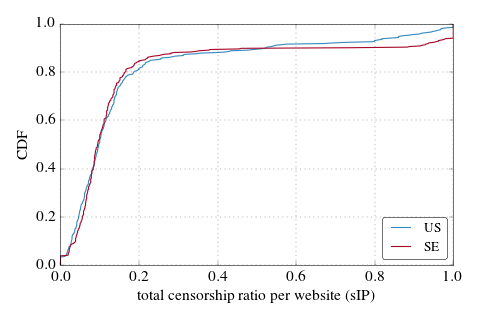

In [84]:
fig1, ax1 = plt.subplots(1,1, figsize=(6,4))

x,y = getCDF( list( df_wanted['US'] ) )
ax1.plot(x,y, label='US')
x,y = getCDF( list( df_wanted['SE'] ) )
ax1.plot(x,y, label='SE')

ax1.set_xlabel("total censorship ratio per website (sIP)")
ax1.set_ylabel("CDF")
ax1.grid(1)
ax1.legend(loc='best', fontsize=12)
fig1.tight_layout()
fig1.show()

# Establishing GT
- alexa top 50 in each subcat was reduced to 403 due to (-http_ip_reachable -anycast_confirmed -15meas)
- the +interesting domains (5) should be added to the sIP list later
- of these 403 we expect no censorship at all so
- run 15 measurements per IP in SE/US (considered as friendly uncensored countries) [Apr 12 dataset]
- if censorship is found - consider it as blockage
- but in our measurements we still see some censorship => false reports due to limitations of our technique
- maybe something on server end
- get the distribution, look at distribution
- data shows a conservative threshold of 0.2

## Consider threshold of 0.2 censorship in 348 domains + not important - cut off

In [85]:
THRESH = 0.2
print len(df_wanted)

403


In [86]:
type1 = df_wanted[ ( (df_wanted['US'] > THRESH) | (df_wanted['SE'] > THRESH) ) ]
print len( type1 )
#print len( type1[ type1['sIP'].isin(bad_sIP1 + bad_sIP2) ] )

91


## Save the rejected IPs (91) and the accepted IPs

In [87]:
# rejected sIPs based on threshold 0.2
type1[['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC_censorship15_unhealthy_.txt', index=False)
print len(type1)

91


In [88]:
# accepted healthy sIPs with thresh 0.2
df_final = df_wanted[ ( (df_wanted['US'] <= THRESH) & (df_wanted['SE'] <= THRESH) ) ]
print len(df_final)
df_final[['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC_censorship15_healthy.txt', index=False)

312


# FINAL Servers_IMC with healthy sIPs + interesting domains to be tested

In [89]:
df_servers_IMC = pd.concat([df_final, less_meas[less_meas['important'] == 1]])
print len(df_final), len(less_meas[less_meas['important'] == 1]), len(df_servers_IMC)

312 5 317


### save to Servers_IMC

In [90]:
df_servers_IMC[['sIP', 'domain', 'subcat']].to_csv('data/Servers_IMC.txt', index=False)

# CONCLUSION
- Only Apr 12
- US AND SE > 15 measurements
- US AND SE < 20% threshold censorship
- Add the 5 interesting domain
- any claim on censorship now is valid in comparison to both US and SE
- as if a domain was more than 0.2 censored in both SE AND US => our technique was bad for that sIP and we can't explain it

In [91]:
less_meas[less_meas['important'] == 1]

,sIP,domain,subcat,US,US-tot,US-1,US-3,SE,SE-tot,SE-1,SE-3,important
90,194.109.206.212,torDir,circum,0.500000,2,1,0,0,2,0,0,1
104,193.23.244.244,torDir,circum,0.333333,3,1,0,0,3,0,0,1
511,131.188.40.189,torDir,circum,0.000000,3,0,0,0,2,0,0,1
518,50.62.247.1,f2cf.org,circum,0.000000,2,0,0,0,3,0,0,1
528,199.254.238.52,torDir,circum,0.000000,2,0,0,0,1,0,0,1


 # Chop sIPs into 3 batches

In [92]:
valid_sIP = df_servers_IMC[['sIP', 'domain', 'subcat']]
indices = list(valid_sIP.index)
np.random.shuffle(indices)
valid_sIP = valid_sIP.reindex(indices)

N = len(valid_sIP)
# chunk 1, 2, 3
valid_sIP.iloc[0:N//3].to_csv(RESULTS + "alexa-ips-2015-04-26-T.txt", index=False, header=False)
valid_sIP.iloc[N//3:2*N//3].to_csv(RESULTS + "alexa-ips-2015-04-26-F.txt", index=False, header=False)
valid_sIP.iloc[2*N//3:].to_csv(RESULTS + "alexa-ips-2015-04-26-S.txt", index=False, header=False)

In [93]:
len(valid_sIP)

317

In [94]:
RESULTS

'results/sIP_sanitize_20150426/'